#  Make plots of subject responses hit/miss/RTs/DET etc 

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns; sns.set()
import scipy
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from scipy import stats
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
sns.set_style("white")
sns.set_style("ticks")

In [2]:
# url = './dataAnalysis/data/csvs/pooled_subject_response_acoustic_feats_data_euc.csv'
url = './data/csvs/praat_pooled_subject_response_acoustic_feats_data_euc.csv'
path_store_figure = './figures/'

In [3]:
# function definitions
# funcs definitions to make significant plot markers 
def barplot_annotate_brackets(num1, num2, data, center, height, yerr=None, dh=.05, barh=.05, hdist=1,fs=None, maxasterix=None,fsize=14):
    """ 
    Annotate barplot with p-values.

    :param num1: number of left bar to put bracket over
    :param num2: number of right bar to put bracket over
    :param data: string to write or number for generating asterixes
    :param center: centers of all bars (like plt.bar() input)
    :param height: heights of all bars (like plt.bar() input)
    :param yerr: yerrs of all bars (like plt.bar() input)
    :param dh: height offset over bar / bar + yerr in axes coordinates (0 to 1)
    :param barh: bar height in axes coordinates (0 to 1)
    :param fs: font size
    :param maxasterix: maximum number of asterixes to write (for very small p-values)
    """

    if type(data) is str:
        text = data
    else:
        # * is p < 0.05
        # ** is p < 0.005
        # *** is p < 0.0005
        # etc.
        text = ''
        p = .05

        while data < p:
            text += '*'
            p /= 10.

            if maxasterix and len(text) == maxasterix:
                break

        if len(text) == 0:
            text = 'n. s.'

    lx, ly = center[num1], height[num1]
    rx, ry = center[num2], height[num2]

    if yerr:
        ly += yerr[num1]
        ry += yerr[num2]

    ax_y0, ax_y1 = plt.gca().get_ylim()
    dh *= (ax_y1 - ax_y0)
    barh *= (ax_y1 - ax_y0)

    y = max(ly, ry) + dh

    barx = [lx, lx, rx, rx]
    bary = [y, y+barh, y+barh, y]
    mid = ((lx+rx)/2, y+barh+hdist)

    plt.plot(barx, bary, c='black')

    kwargs = dict(ha='center', va='bottom')
    if fs is not None:
        kwargs['fontsize'] = fs

    plt.text(*mid, text, **kwargs,fontsize=fsize)


In [4]:
# load csv into a dataframe
DF = pd.read_csv(url)
# prune the outliers
DF['RT'] = DF['t_resp'] - DF['t_end'] # make a response time column
indx = []
indx.append(DF.loc[DF['session'] == 'TRAIN'].index.to_numpy()) # pick train samples
# indx.append(np.where(DF["label-response"].values !=0)[0]) # pick correct response
indx.append(np.where(DF["response"].values <0)[0]) # pick correct response
# indx.append(DF.loc[DF['lang'] == 0].index.to_numpy()) # chinese
# indx.append(DF.loc[DF['lang'] == 1].index.to_numpy()) # english
indx.append(np.where(DF["RT"].values <0.02)[0]) # pick RT<200 msec
indx.append(np.where(DF["RT"].values >2)[0]) # pick RT>2000 msec

In [5]:
# pool indices to drop
indx_drop  = list(set(indx[0]) | set(indx[1]) | set(indx[2]) | set(indx[3]))

In [6]:
DF_pruned = DF.copy()
DF_pruned = DF_pruned.drop(index=indx_drop,axis=0)
DF_pruned['incorrect'] = np.abs(DF['label'] - DF['response']) # make a correct response column
DF_pruned
print('Percentage bad trials:')
print(100-len(DF_pruned)/(200*28)*100)

Percentage bad trials:
6.714285714285722


In [7]:
# get MISS and FA and RTs correct and incorrect of trials
nstim_spkr_2 = [[],[]]
nstim_spkr_1 = [[],[]]
nresp_hit = [[],[]]
nresp_fa = [[],[]]

# RTs
rt_pool_correct = [[],[]]
rt_pool_incorrect =  [[],[]]

rt_spkr_1 = [[],[]]
rt_spkr_2 = [[],[]]


rt_subject_wise_correct = [[],[]]
rt_subject_wise_incorrect = [[],[]]

for i in range(1,29):
    for j in range(2):
        temp = DF_pruned.loc[(DF_pruned['subID']==i) & (DF_pruned['lang']==j)]
        nstim_spkr_2[j].append(temp.loc[temp['label']==2].shape[0])
        nresp_hit[j].append(temp.loc[(temp['label']==2) & (temp['response']==2)].shape[0])
        nstim_spkr_1[j].append(temp.loc[temp['label']==1].shape[0])
        nresp_fa[j].append(temp.loc[(temp['label']==1) & (temp['response']==2)].shape[0])
        
        rt_spkr_1[j].extend(temp.loc[(temp['label']==1) & (temp['incorrect']==0) & (temp['RT']>.020)]["RT"].to_numpy())
        rt_spkr_2[j].extend(temp.loc[(temp['label']==2) & (temp['incorrect']==0) & (temp['RT']>.020)]["RT"].to_numpy())

        rt_pool_correct[j].extend(temp.loc[(temp['incorrect']==0) & (temp['RT']>.020)]["RT"].to_numpy())
        rt_pool_incorrect[j].extend(temp.loc[(temp['incorrect']==1) & (temp['RT']>.020)]["RT"].to_numpy())
        rt_subject_wise_correct[j].append(np.mean(temp.loc[(temp['incorrect']==0) & (temp['RT']>.020)]["RT"].to_numpy()))
        rt_subject_wise_incorrect[j].append(np.mean(temp.loc[(temp['incorrect']==1) & (temp['RT']>.020)]["RT"].to_numpy()))
                                            
                                    

In [8]:
DF_pruned

,fIndex,fname,label,response,session,t_start,t_end,t_resp,subID,pitch,mfcc,mel,scentroid,harm,intensity,xvec,lang,changeIns,RT,incorrect
6,60,./playback/STIMULI/chinese/wavFilesTest/BAC009...,1,1,TEST,0.0,6.524,7.100,1,20.032631,15.416758,21.344948,74.961257,1.912879,0.990359,34.422130,0,2.72,0.576,0
7,23,./playback/STIMULI/chinese/wavFilesTest/BAC009...,1,1,TEST,0.0,7.561,8.018,1,1.526730,21.670540,22.098153,213.698193,0.341891,0.392727,31.215648,0,3.02,0.457,0
8,53,./playback/STIMULI/chinese/wavFilesTest/BAC009...,2,2,TEST,0.0,7.803,8.483,1,4.348192,40.323444,42.471694,227.746250,1.003327,0.329294,57.658610,0,3.08,0.680,0
9,15,./playback/STIMULI/chinese/wavFilesTest/BAC009...,2,1,TEST,0.0,7.217,7.644,1,3.504757,23.900738,26.144663,100.745825,1.987600,0.021779,55.116579,0,3.56,0.427,1
10,45,./playback/STIMULI/chinese/wavFilesTest/BAC009...,2,1,TEST,0.0,5.143,5.703,1,1.695239,44.494479,45.744007,11.257437,0.203285,2.518086,46.407622,0,2.53,0.560,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6040,70,./playback/STIMULI/english/wavFilesTest/4044-9...,1,1,TEST,0.0,7.206,7.736,28,93.468495,20.964933,37.822411,109.178375,0.255397,3.637914,35.007372,1,3.17,0.530,0
6041,25,./playback/STIMULI/english/wavFilesTest/1594-1...,2,2,TEST,0.0,7.117,7.976,28,0.951037,48.133883,48.572000,478.179817,4.758491,4.574607,44.726704,1,3.56,0.859,0
6042,73,./playback/STIMULI/english/wavFilesTest/4137-1...,1,1,TEST,0.0,8.693,9.308,28,35.104073,30.971736,34.590062,99.535889,2.343633,0.593506,33.810017,1,3.69,0.615,0
6043,13,./playback/STIMULI/english/wavFilesTest/1246-1...,2,2,TEST,0.0,6.977,7.760,28,7.740520,46.629519,51.018089,456.791340,4.249000,2.710184,47.511349,1,3.60,0.783,0


In [9]:
# convert lists to np.array
rt_subject_wise_correct = np.array(rt_subject_wise_correct)
rt_subject_wise_incorrect = np.array(rt_subject_wise_incorrect)
nstim_spkr_1 = np.array(nstim_spkr_1)
nstim_spkr_2 = np.array(nstim_spkr_2)
nresp_hit = np.array(nresp_hit)
nresp_fa = np.array(nresp_fa)

In [10]:
# obtain miss and fa percentage
miss = ((1-np.divide(nresp_hit,nstim_spkr_2))).T
fa = ((np.divide(nresp_fa,nstim_spkr_1))).T


In [11]:
print(nresp_fa[0,:])
print(nstim_spkr_1[0,:])

[ 4  2  6  5  4 11  1  0  4  5  7  3  4  3  1  3  6  3  6  8  9  3 21  1
  5 13 11  4]
[44 48 50 47 43 50 49 44 43 49 47 48 49 48 49 47 40 42 49 49 50 46 49 49
 50 50 49 49]


In [12]:
twosample_results = scipy.stats.ttest_ind(miss[:,0], miss[:,1],equal_var=False) # ttest
print('t-test on MISS')
print(twosample_results.statistic)
print(twosample_results.pvalue)

twosample_results = scipy.stats.ttest_ind(fa[:,0], fa[:,1],equal_var=False) # ttest
print('t-test on FA')
print(twosample_results.statistic)
print(twosample_results.pvalue)

t-test on MISS
2.3889330261905544
0.020442905589053165
t-test on FA
-2.802352540985147
0.007037164950005461


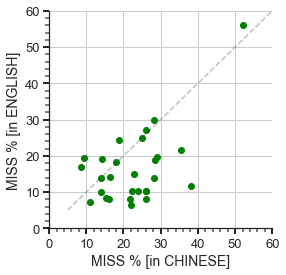

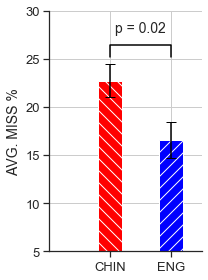

In [13]:
# make plots
# make MISS plots
NSTIM = 1
# scatter plots
fig, ax = plt.subplots(figsize=(4, 4))

ax.scatter(miss[:,0]/NSTIM*100,miss[:,1]/NSTIM*100,color='green')
ax.set_xlabel('MISS % [in CHINESE]',fontsize=14)
ax.set_ylabel('MISS % [in ENGLISH]',fontsize=14)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='both', width=2)
ax.set_xlim(0,60)
ax.set_ylim(0,60)
ax.grid(True)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.plot([5,60],[5,60],'--',color='black',alpha=0.25)
ax.tick_params(which='minor', length=4, color='gray')
ax.figure.savefig(path_store_figure+"human_miss_scatter.pdf", bbox_inches='tight')
plt.show()


fig, ax = plt.subplots(figsize=(3, 4))
ax.bar(2,np.mean(miss[:,0]/NSTIM*100),yerr=np.std(miss[:,0])/NSTIM/np.sqrt(len(miss))*100, align='center',alpha=1, ecolor='black',capsize=5,hatch="\\\\",color='red')
ax.bar(4,np.mean(miss[:,1]/NSTIM*100),yerr=np.std(miss[:,1])/NSTIM/np.sqrt(len(miss))*100, align='center',alpha=1, ecolor='black',capsize=5,hatch="//",color='blue')
ax.set_ylabel('AVG. MISS %',fontsize=14)
# ax.text(1.5,-9,'MEAN',horizontalalignment='center')
plt.xticks([2,4], ['CHIN','ENG'],rotation=0)
ax.set_xlim(0,5)
ax.set_ylim(5,30)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
ax.grid(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# sns.despine()
# Call the function
barplot_annotate_brackets(0, 1, 'p = 0.02', [2,4],[np.mean(miss[:,0]),np.mean(miss[:,1])], dh=1,barh=.05,fsize=14)
plt.tight_layout()
ax.figure.savefig(path_store_figure+"human_miss_mean.pdf", bbox_inches='tight')
plt.show()

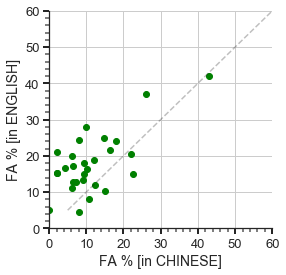

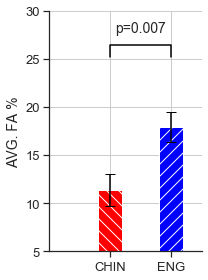

In [14]:
# make FA plots
NSTIM = 1
# scatter plots
fig, ax = plt.subplots(figsize=(4, 4))

ax.scatter(fa[:,0]/NSTIM*100,fa[:,1]/NSTIM*100,color='green')
ax.set_xlabel('FA % [in CHINESE]',fontsize=14)
ax.set_ylabel('FA % [in ENGLISH]',fontsize=14)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='both', width=2)
ax.set_xlim(0,60)
ax.set_ylim(0,60)
ax.grid(True)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.plot([5,60],[5,60],'--',color='black',alpha=0.25)
ax.tick_params(which='minor', length=4, color='gray')
ax.figure.savefig(path_store_figure+"human_fa_scatter.pdf", bbox_inches='tight')
plt.show()


fig, ax = plt.subplots(figsize=(3, 4))
ax.bar(2,np.mean(fa[:,0]/NSTIM*100),yerr=np.std(fa[:,0])/np.sqrt(len(miss))/NSTIM*100, align='center',alpha=1, ecolor='black',capsize=5,hatch="\\\\",color='red')
ax.bar(4,np.mean(fa[:,1]/NSTIM*100),yerr=np.std(fa[:,1])/np.sqrt(len(miss))/NSTIM*100, align='center',alpha=1, ecolor='black',capsize=5,hatch="//",color='blue')
ax.set_ylabel('AVG. FA %',fontsize=14)
# ax.text(1.5,-9,'MEAN',horizontalalignment='center')
plt.xticks([2,4], ['CHIN','ENG'],rotation=0)
ax.set_xlim(0,5)
ax.set_ylim(5,30)
ax.grid(True)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# sns.despine()
# Call the function
barplot_annotate_brackets(0, 1, 'p=0.007', [2,4],[np.mean(fa[:,0]),np.mean(fa[:,1])], dh=1,barh=.05,hdist=1,fsize=14)
plt.tight_layout()

ax.figure.savefig(path_store_figure+"human_fa_mean.pdf", bbox_inches='tight')
plt.show()


-3.0263046736015924
0.003787683066481784


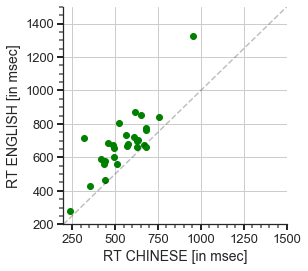

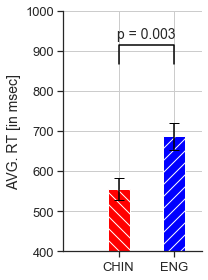

In [15]:
# Make RT correct trials plot
mu_crt = rt_subject_wise_correct.copy()*1000 # in msec
twosample_results = scipy.stats.ttest_ind(mu_crt[0], mu_crt[1])
print(twosample_results.statistic)
print(twosample_results.pvalue)

# make RT plots
# scatter plots
fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(mu_crt[0],mu_crt[1],color='green')
ax.set_xlabel('RT CHINESE [in msec]',fontsize=14)
ax.set_ylabel('RT ENGLISH [in msec]',fontsize=14)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='both', width=2)
ax.set_xlim(200,1500)
ax.set_ylim(200,1500)
ax.grid(True)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.plot([200,1500],[200,1500],'--',color='black',alpha=0.25)
ax.tick_params(which='minor', length=4, color='gray')
ax.figure.savefig(path_store_figure+"human_correct_mean_RT_scatter.pdf", bbox_inches='tight')
plt.show()


fig, ax = plt.subplots(figsize=(3, 4))
ax.bar(2,np.mean(mu_crt[0]),yerr=np.std(mu_crt[0])/np.sqrt(len(miss)), align='center',alpha=1, ecolor='black',capsize=5,hatch="\\\\",color='red')
ax.bar(4,np.mean(mu_crt[1]),yerr=np.std(mu_crt[1])/np.sqrt(len(miss)), align='center',alpha=1, ecolor='black',capsize=5,hatch="//",color='blue')
ax.set_ylabel('AVG. RT [in msec]',fontsize=14)
# ax.text(1.5,-9,'MEAN',horizontalalignment='center')
plt.xticks([2,4], ['CHIN','ENG'],rotation=0)
ax.set_xlim(0,5)
ax.set_ylim(400,1000)
ax.grid(True)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# sns.despine()
# Call the function
barplot_annotate_brackets(0, 1, 'p = 0.003', [2,4],[np.mean(mu_crt[0]),np.mean(mu_crt[1])], dh=.3,barh=.08,hdist=10,fsize=14)
plt.tight_layout()
ax.figure.savefig(path_store_figure+"human_correct_mean_RT.pdf", bbox_inches='tight')
plt.show()


-4.095202660564263
0.00014215809092348164


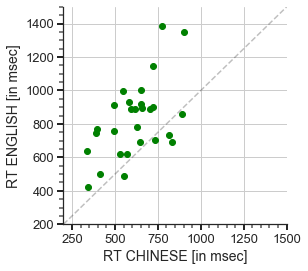

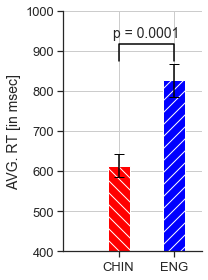

In [16]:
# Make RT incorrect trials plot
mu_icrt = rt_subject_wise_incorrect.copy()*1000 # in msec
twosample_results = scipy.stats.ttest_ind(mu_icrt[0], mu_icrt[1])
print(twosample_results.statistic)
print(twosample_results.pvalue)

# make RT plots
# scatter plots
fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(mu_icrt[0],mu_icrt[1],color='green')
ax.set_xlabel('RT CHINESE [in msec]',fontsize=14)
ax.set_ylabel('RT ENGLISH [in msec]',fontsize=14)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='both', width=2)
ax.set_xlim(200,1500)
ax.set_ylim(200,1500)
ax.grid(True)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.plot([200,1500],[200,1500],'--',color='black',alpha=0.25)
ax.tick_params(which='minor', length=4, color='gray')
ax.figure.savefig(path_store_figure+"human_incorrect_mean_RT_scatter.pdf", bbox_inches='tight')
plt.show()


fig, ax = plt.subplots(figsize=(3, 4))
ax.bar(2,np.mean(mu_icrt[0]),yerr=np.std(mu_icrt[0])/np.sqrt(len(miss)), align='center',alpha=1, ecolor='black',capsize=5,hatch="\\\\",color='red')
ax.bar(4,np.mean(mu_icrt[1]),yerr=np.std(mu_icrt[1])/np.sqrt(len(miss)), align='center',alpha=1, ecolor='black',capsize=5,hatch="//",color='blue')
ax.set_ylabel('AVG. RT [in msec]',fontsize=14)
# ax.text(1.5,-9,'MEAN',horizontalalignment='center')
plt.xticks([2,4], ['CHIN','ENG'],rotation=0)
ax.set_xlim(0,5)
ax.set_ylim(400,1000)
ax.grid(True)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# sns.despine()
# Call the function
barplot_annotate_brackets(0, 1, 'p = 0.0001', [2,4],[np.mean(mu_icrt[0]),np.mean(mu_icrt[1])], dh=.08,barh=.07,hdist=10,fsize=14)
plt.tight_layout()
ax.figure.savefig(path_store_figure+"human_incorrect_mean_RT.pdf", bbox_inches='tight')
plt.show()

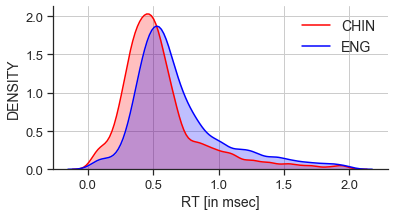

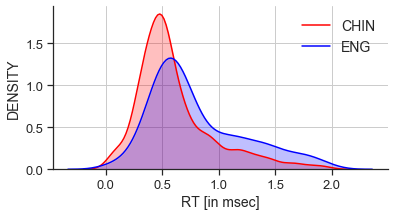

In [17]:
# make RT distribution plot
crt = rt_pool_correct.copy()
icrt = rt_pool_incorrect.copy()

fig = plt.subplots(figsize=(6,3))
ax = plt.subplot(1,1,1)
sns.kdeplot(crt[0], shade=True,color='red',label='CHIN')
sns.kdeplot(crt[1], shade=True,color='blue',label='ENG')
ax.grid(True)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('RT [in msec]',fontsize=14)
ax.set_ylabel('DENSITY',fontsize=14)
ax.legend(loc='upper right',frameon=False,fontsize=14)
ax.figure.savefig(path_store_figure+"human_rt_correct_all.pdf", bbox_inches='tight')
plt.show()

fig = plt.subplots(figsize=(6,3))
ax = plt.subplot(1,1,1)
kde = sns.kdeplot(icrt[0], shade=True,color='red',label='CHIN')
kde = sns.kdeplot(icrt[1], shade=True,color='blue',label='ENG')
hatches = ["/", "o", "*", "\\"]
for hatch, patch in zip(hatches, kde.artists):
    patch.set_hatch(hatch)
ax.grid(True)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('RT [in msec]',fontsize=14)
ax.set_ylabel('DENSITY',fontsize=14)
ax.legend(loc='upper right',frameon=False,fontsize=14)
ax.figure.savefig(path_store_figure+"human_rt_incorrect_all.pdf", bbox_inches='tight')
plt.show()

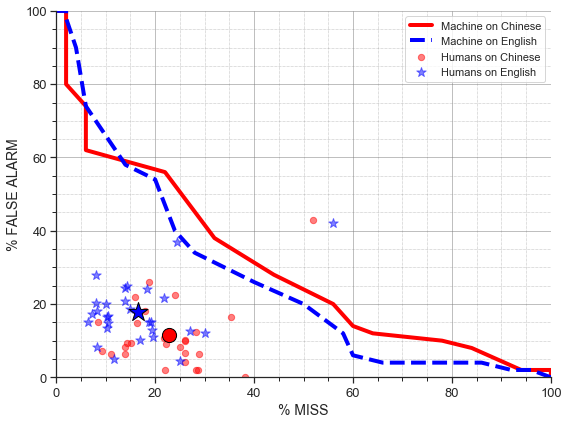

In [18]:
# make DET curve 
# obtaining the DET curves:
machine_scores = [[],[]]
machine_scores[0] = pd.read_csv('./rocData/stats_ahcfull_c.csv')
machine_scores[1] = pd.read_csv('./rocData/stats_ahcfull__e.csv')


sns.set_style("white")
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(machine_scores[0]['Miss_e'], machine_scores[0]['FA_e'],linewidth = 4,\
        color='red',label='Machine on Chinese')
ax.plot(machine_scores[1]['Miss_e'], machine_scores[1]['FA_e'],linestyle='dashed',linewidth = 4,\
        color='blue',label='Machine on English')
ax.scatter(miss[:,0]*100, fa[:,0]*100,alpha = 0.5,s=40,color='red',label='Humans on Chinese')
ax.scatter(miss[:,1]*100, fa[:,1]*100,alpha = 0.5,s=100,marker= '*',color='blue',label='Humans on English')
ax.scatter(np.mean(miss[:,0]*100), np.mean(fa[:,0]*100),s=200,marker = 'o',color='red',edgecolors ='black')
ax.scatter(np.mean(miss[:,1]*100), np.mean(fa[:,1]*100),s=400,marker = '*',color='blue',edgecolors ='black')
plt.grid(True)
ax.minorticks_on()

# Customize the major grid
ax.grid(which='major', linestyle='-', linewidth='0.5', color='gray')
# Customize the minor grid
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
ax.set_xlim(0,100)
ax.set_ylim(0,100)
sns.despine()
ax.legend(loc='upper right')
plt.xlabel("% MISS",fontsize=14)
plt.ylabel("% FALSE ALARM",fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()
ax.figure.savefig(path_store_figure+"DET_machine_human.pdf", bbox_inches='tight')
plt.show()
